In [110]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [111]:
data_path = './PoVeKamon/Images/Data/'
obj1_path = './PoVeKamon/Images/Object.png'
obj2_path = './PoVeKamon/Images/Object2.png'

print(os.path.exists(data_path))
print(os.path.exists(obj1_path))
print(os.path.exists(obj2_path))

True
True
True


In [112]:
def loadpro(path):
    img = cv2.imread(path)

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.equalizeHist(img_gray)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), img_gray

In [113]:
obj1, obj1_gray = loadpro(obj1_path)
obj1_gray = cv2.medianBlur(obj1_gray, 5)

obj2, obj2_gray = loadpro(obj2_path)
obj2_gray = cv2.GaussianBlur(obj2_gray, (3, 3), 0)

In [114]:
akaze=cv2.AKAZE.create()
obj1_kp, obj1_desc = akaze.detectAndCompute(obj1_gray, None)
obj2_kp, obj2_desc= akaze.detectAndCompute(obj2_gray, None)

In [115]:
def featurematch(desc, target_desc):
    flann = cv2.FlannBasedMatcher(dict(algorithm = 1), dict(checks = 50))
    matches = flann.knnMatch(np.float32(target_desc), desc, k=2)
    matches_mask = [[0, 0] for _ in range(len(matches))]

    curr_m = 0

    for i, (fm, sm) in enumerate(matches):
        if fm.distance <0.7*sm.distance:
            curr_m+=1
            matches_mask[i] = [1, 0]
    return matches, matches_mask, curr_m

In [116]:
best1 = 0
best2 = 0

for file in os.listdir(data_path):
    img, img_gray = loadpro(data_path + file)

    img_gray1 = cv2.medianBlur(img_gray, 5)
    img_gray2 = cv2.GaussianBlur(img_gray, (3, 3), 0)

    img1_kp, img1_desc = akaze.detectAndCompute(img_gray1, None)
    img2_kp, img2_desc = akaze.detectAndCompute(img_gray2, None)

    img1_desc = np.float32(img1_desc)
    img2_desc = np.float32(img2_desc)

    matches1, matches_mask1, curr_match1 = featurematch(img1_desc, obj1_desc)
    matches2, matches_mask2, curr_match2 = featurematch(img2_desc, obj2_desc)

    if curr_match1 > best1:
        best1 = curr_match1
        best1_data = {
            "img" : img,
            "keypoints" : img1_kp,
            "matches" : matches1, 
            "mask" : matches_mask1
        }

    if curr_match2 > best2:
        best2 = curr_match2
        best2_data = {
            "img" : img, 
            "keypoints" : img2_kp, 
            "matches" : matches2, 
            "mask" :matches_mask2

        }
print("success")

success


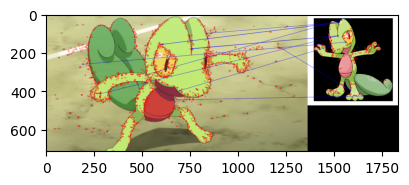

In [119]:
plt.figure(figsize =(10,8))
plt.subplot(1, 2, 1)
result = cv2.drawMatchesKnn(
    obj1, obj1_kp,
    best1_data["img"], best1_data["keypoints"], best1_data["matches"], None,
    matchColor=(0, 0, 255), singlePointColor=(255, 0, 0),
    matchesMask= best1_data['mask']
)
plt.imshow(result)